In [1]:
__author__ = 'Knut Olsen <knut.olsen@noirlab.edu' # single string; emails in <>
__version__ = '20210330' # yyyymmdd; version datestamp of this notebook
__datasets__ = ['delve_dr1']  # datasets used in this notebook; for available datasets, see cell "Available datasets in Data Lab" further below
__keywords__ = [''], # keywords relevant to this notebook, e.g. ['science case','dwarf galaxies'] Use only keywords from the master list: https://github.com/noaodatalab/notebooks-latest/blob/master/internal/keywords.txt

# Accessing the DELVE DR1 catalog
*Knut Olsen* and the DELVE Team

### Table of contents
* [Summary](#summary)
* [Disclaimer & Attribution](#attribution)
* [Imports & setup](#import)
* [Accessing the database](#database)
* [Resources and references](#resources)

<a class="anchor" id="summary"></a>

# Summary
This is a brief intro to using the DELVE DR1 catalog through Data Lab.

<a class="anchor" id="attribution"></a>
# Disclaimer & attribution
If you use this notebook for your published science, please acknowledge the following:

* Data Lab concept paper: Fitzpatrick et al., "The NOAO Data Laboratory: a conceptual overview", SPIE, 9149, 2014, http://dx.doi.org/10.1117/12.2057445

* Data Lab disclaimer: http://datalab.noao.edu/disclaimers.php

<a class="anchor" id="import"></a>
# Imports and setup

In [2]:
# std lib
from getpass import getpass

# 3rd party # remove imports that are not needed
import numpy as np
import pylab as plt
import matplotlib
import healpy as hp
%matplotlib inline

# Data Lab
from dl import authClient as ac, queryClient as qc, storeClient as sc

<a class="anchor" id="database"></a>
# Accessing the database

First check that you're logged in. If not, and you need it (e.g. because you want to access you user MyDB or VOSpace storage to save results), use the commented code to log in to the server. Your token is stored on the server, so you will remain logged in unless you explicitly log out.

In [3]:
ac.whoAmI()
# token = ac.login(input("Enter user name: (+ENTER) "),getpass("Enter password: (+ENTER) "))

'robertdemo'

### List the columns
You can use the queryClient.schema() method to list the column names of the DELVE object table.

In [4]:
# schema and table names
wide_schema = 'delve_dr1'
wide_object = 'objects'

In [5]:
print(qc.schema(wide_schema+'.'+wide_object))


Schema: delve_dr1
 Table: objects

     Column Name   Description
     -----------   -----------
 quick_object_id   Unique identifier for each object
         hpx2048   NSIDE 2048 HEALPix index, in RING scheme, for each object
       mag_psf_g   PSF magnitude in g-band (see SExtractor manual for details)
       mag_psf_r   PSF magnitude in r-band (see SExtractor manual for details)
       mag_psf_i   PSF magnitude in i-band (see SExtractor manual for details)
       mag_psf_z   PSF magnitude in z-band (see SExtractor manual for details)
    magerr_psf_g   PSF magnitude error in g-band (see SExtractor manual for d
                   etails)
    magerr_psf_r   PSF magnitude error in r-band (see SExtractor manual for d
                   etails)
    magerr_psf_i   PSF magnitude error in i-band (see SExtractor manual for d
                   etails)
    magerr_psf_z   PSF magnitude error in z-band (see SExtractor manual for d
                   etails)
      mag_auto_g   Automatic apertur

### A basic query
We'll make a basic query, and return the output as a Pandas dataframe.  You can write your query as SQL (Postgres).

In [6]:
sql = '''SELECT * FROM {} LIMIT 10'''.format(wide_schema+'.'+wide_object)
print(sql)
df = qc.query(sql=sql,fmt='pandas')

SELECT * FROM delve_dr1.objects LIMIT 10


In [7]:
df

,quick_object_id,ra,dec,hpx2048,mag_psf_g,mag_psf_r,mag_psf_i,mag_psf_z,magerr_psf_g,magerr_psf_r,...,flags_z,wavg_flags_g,wavg_flags_r,wavg_flags_i,wavg_flags_z,ring32,extended_class_g,extended_class_r,extended_class_i,extended_class_z
0,10766300081745,133.134802,-14.361652,41720290,23.5996,22.5611,22.7346,99.0000,0.124050,0.066878,...,99,0,1,0,99,7663,3,3,3,-9
1,10766300023258,133.123605,-14.361105,41720290,16.8652,16.1045,99.0000,15.7301,0.001122,0.000960,...,0,0,0,99,0,7663,0,0,-9,0
2,10766300142603,133.123128,-14.359402,41720290,21.5479,21.0712,20.9822,20.9355,0.022698,0.019290,...,0,0,0,0,0,7663,0,0,0,1
3,10766300142605,133.125686,-14.358975,41720290,99.0000,23.4074,21.6697,20.9924,99.000000,0.143690,...,0,99,0,0,0,7663,-9,1,0,0
4,10766300126631,133.129967,-14.358373,41720290,22.7392,21.7747,21.8092,21.5581,0.057766,0.033865,...,0,0,2,0,0,7663,3,3,3,3
5,10766300182183,133.122807,-14.355769,41720290,99.0000,99.0000,99.0000,22.0365,99.000000,99.000000,...,0,99,99,99,0,7663,-9,-9,-9,1
6,10766300081732,133.124278,-14.353962,41720290,23.4038,21.4387,20.9568,20.4420,0.104253,0.025770,...,0,0,0,0,0,7663,3,3,3,3
7,10766300126635,133.130359,-14.360158,41720290,21.7879,21.0343,21.4542,20.9505,0.026283,0.018244,...,0,0,0,0,0,7663,3,3,3,3
8,10766300081743,133.134671,-14.358465,41720290,24.0474,22.9961,22.8813,99.0000,0.176411,0.099295,...,99,0,0,0,99,7663,2,2,2,-9
9,10766300070955,133.134690,-14.356422,41720290,18.0326,17.4620,17.3048,17.2386,0.002594,0.001928,...,0,0,0,0,0,7663,0,0,0,0


### Another basic query
Here we'll look for objects associated with a specific exposure number.

In [8]:
%%time
sql = '''SELECT * FROM {} WHERE expnum_g=605691'''.format(wide_schema+'.'+wide_object)
df1 = qc.query(sql=sql,fmt='pandas')

CPU times: user 4.4 s, sys: 896 ms, total: 5.29 s
Wall time: 18.6 s


### A cone search
Data Lab uses Q3C indices to speed up cone search queries.  Here's an example:

In [9]:
ra,dec = df1['ra'][0],df1['dec'][0]

In [10]:
sql = '''SELECT ra,dec,mag_auto_g,mag_auto_i FROM {2} where Q3C_RADIAL_QUERY(ra,dec,{0},{1},1.2)'''.format(ra,dec,wide_schema+'.'+wide_object)
print(sql)

SELECT ra,dec,mag_auto_g,mag_auto_i FROM delve_dr1.objects where Q3C_RADIAL_QUERY(ra,dec,132.991610699796,-25.4089568533361,1.2)


In [11]:
%%time
dfr = qc.query(sql=sql,fmt='pandas')

CPU times: user 894 ms, sys: 283 ms, total: 1.18 s
Wall time: 7.73 s


In [12]:
print(len(dfr))

446041


Text(0, 0.5, 'Dec')

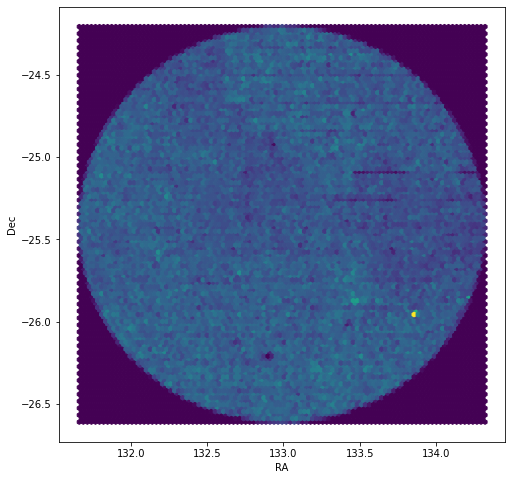

In [13]:
plt.figure(figsize=(8,8))
plt.hexbin(dfr['ra'],dfr['dec'])
plt.xlabel('RA')
plt.ylabel('Dec')

Text(0, 0.5, 'g')

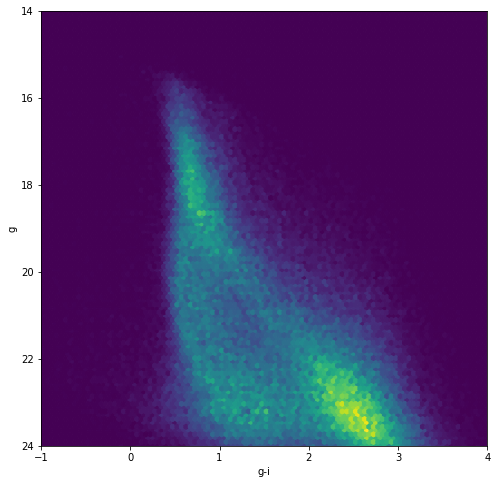

In [14]:
plt.figure(figsize=(8,8))
plt.hexbin(dfr['mag_auto_g']-dfr['mag_auto_i'],dfr['mag_auto_g'],extent=(-1,4,14,24))
plt.xlim(-1,4)
plt.ylim(24,14)
plt.xlabel('g-i')
plt.ylabel('g')

### Make a density map
Here we'll issue a query that aggregates objects by their Healpix ID on an NSIDE=256 RING scheme, and display the object density map.

In [15]:
%%time
sql = '''SELECT AVG(ra) AS ra0, AVG(dec) AS dec0, COUNT(ra) as nb, ring256 FROM {} GROUP BY ring256'''.format(wide_schema+'.'+wide_object)
df2 = qc.query(sql=sql,fmt='pandas',timeout=600)

CPU times: user 331 ms, sys: 664 µs, total: 332 ms
Wall time: 56.6 s


In [16]:
map = np.zeros(hp.nside2npix(256))
map[df2['ring256']] = df2['nb']

/home/robert/miniconda3/envs/py38/lib/python3.8/site-packages/healpy/projaxes.py:920: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("viridis").copy()
  newcm.set_over(newcm(1.0))
/home/robert/miniconda3/envs/py38/lib/python3.8/site-packages/healpy/projaxes.py:921: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("viridis").copy()
  newcm.set_under(bgcolor)
/home/robert/miniconda3/envs/py38/lib/python3.8/site-packages/healpy/projaxes.py:922: MatplotlibDeprecationWarning: You are modifying the state of a g

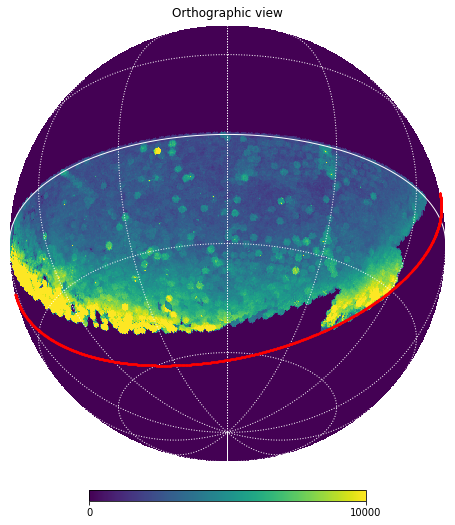

In [17]:
lon = np.arange(3600)/10
lat = np.zeros(3600)
plt.figure(figsize=(8,8))
hp.orthview(map,rot=(180,-30),min=0,max=10000,half_sky=True,fig=1,coord='C',notext=True)
hp.graticule(c='w')
foo = hp.projplot(lon,lat,'ro',coord='G',lonlat=True,markersize=1)

### Star/galaxy separation in DELVE-WIDE
The delve_dr1.objects catalog has several columns, named extended_class[g,r,i,z], that contain a morphological class based on the spread_model parameter.  Objects with extended_class = 0 or 1 are likely point sources, see the [DES DR1 paper](https://www.darkenergysurvey.org/wp-content/uploads/2018/01/DR1Release.pdf) for details.

In [18]:
# select point sources with g-r<0.75, 19.5<g<22, and gerr<0.2
delvequery = """SELECT avg(ra) as ra0,avg(dec) as dec0,hpx2048,count(hpx2048) as nb
           FROM {}
           WHERE 
           (mag_auto_g-mag_auto_r)<0.75 AND mag_auto_g>19.5 AND magerr_auto_g<0.2
           AND extended_class_g <= 1 AND extended_class_r <= 1 AND extended_class_g > -1 AND extended_class_r > -1
           GROUP BY hpx2048
        """.format(wide_schema+'.'+wide_object)
print(delvequery)

SELECT avg(ra) as ra0,avg(dec) as dec0,hpx2048,count(hpx2048) as nb
           FROM delve_dr1.objects
           WHERE 
           (mag_auto_g-mag_auto_r)<0.75 AND mag_auto_g>19.5 AND magerr_auto_g<0.2
           AND extended_class_g <= 1 AND extended_class_r <= 1 AND extended_class_g > -1 AND extended_class_r > -1
           GROUP BY hpx2048
        


In [19]:
%%time
df_ps = qc.query(sql = delvequery, fmt='pandas', timeout=600)

CPU times: user 8.41 s, sys: 2.7 s, total: 11.1 s
Wall time: 2min 37s


In [20]:
map_ps = np.zeros(hp.nside2npix(2048))
map_ps[df_ps['hpx2048']] = df_ps['nb'] # NB: hpx2048 is on the NESTed scheme

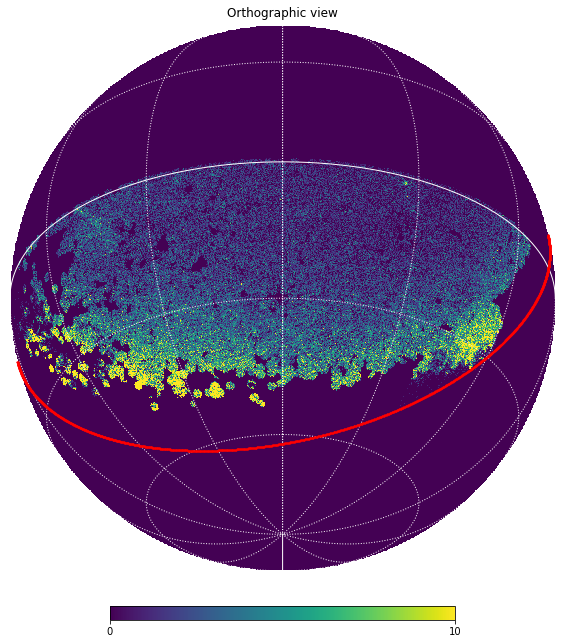

In [21]:
plt.figure(figsize=(10,10))
hp.orthview(map_ps,rot=(180,-30),min=0,max=10,half_sky=True,fig=1,coord='C',notext=True,nest=True)
hp.graticule(c='w')
foo = hp.projplot(lon,lat,'ro',coord='G',lonlat=True,markersize=1)

The map might look smoother if we downgrade the resolution a bit.

In [22]:
map_ps256 = hp.ud_grade(map_ps,256,order_in='NESTED',order_out='NESTED')

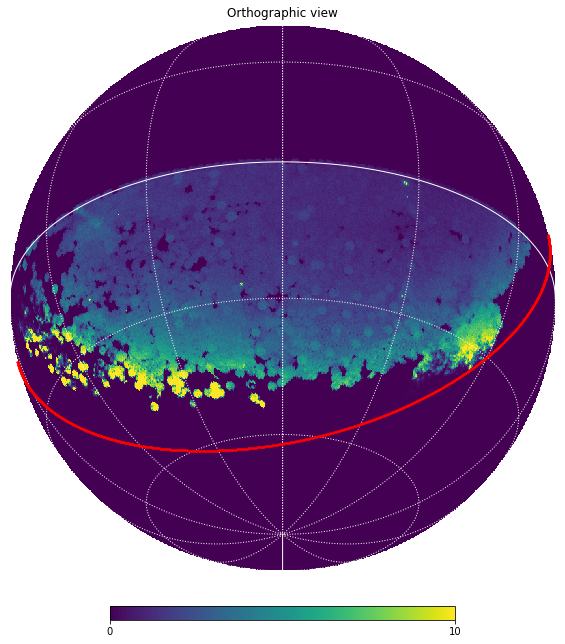

In [23]:
plt.figure(figsize=(10,10))
hp.orthview(map_ps256,rot=(180,-30),min=0,max=10,half_sky=True,fig=1,coord='C',notext=True,nest=True)
hp.graticule(c='w')
foo = hp.projplot(lon,lat,'ro',coord='G',lonlat=True,markersize=1)

### More info
Have a look at the HowTos and Science Examples folders in the notebooks directory for other things you might want to learn how to do.